# Exploring Dandiset 000563: Allen Institute Openscope - Barcoding

This notebook was generated with the assistance of AI. Please be cautious when interpreting the code or results.

## Overview

This Dandiset presents electrophysiological data from mouse visual system experiments designed to investigate the temporal precision of neuronal responses to visual white noise stimuli. The dataset focuses on the "barcoding" phenomenon seen in spike responses of cortical and subcortical neurons, where repeated white noise stimuli evoke highly precise and repeatable "barcode-like" patterns.

**Key features:**
- Multi-electrode (Neuropixels) extracellular recordings
- Visual stimuli: full-field flicker and static gratings driven by repeated white noise sequences
- Optogenetic stimulation data
- Behavioral tracking: eye tracking and running wheel
- 94 NWB files, 200 GB data, 14 subjects

**Important note:** LFP timestamps in this dataset are in milliseconds, not seconds.

**Dandiset link:** https://dandiarchive.org/dandiset/000563/0.250311.2145

## Required Packages

This notebook requires the following packages:
- `dandi`
- `pynwb`
- `h5py`
- `remfile`
- `numpy`
- `matplotlib`
- `pandas`

In [1]:
import h5py
import pynwb
import remfile
from dandi.dandiapi import DandiAPIClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Exploring the Dandiset with DANDI API

In [2]:
# Connect to DANDI and get dandiset metadata
client = DandiAPIClient()
dandiset = client.get_dandiset("000563", "0.250311.2145")
metadata = dandiset.get_raw_metadata()

print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")
print(f"Description: {metadata.get('description', 'No description available')[:200]}...")

Dandiset name: Allen Institute Openscope - Barcoding
Dandiset URL: https://dandiarchive.org/dandiset/000563/0.250311.2145
Description: Some visual neurons have been shown to respond to white noise flicker visual stimuli with high temporal precision, particularly retinal ganglion cells and LGN relay cells. Responses to white noise sti...


## Exploring NWB Files in the Dandiset

In [3]:
# List all NWB files and identify main data files
assets = list(dandiset.get_assets_by_glob("*.nwb"))

# Compile file information
file_list = []
for asset in assets:
    file_info = {
        'path': asset.path,
        'size_gb': round(asset.size / 1e9, 2)
    }
    file_list.append(file_info)

# Files with 'ogen' typically contain optogenetic or main session data
ogen_files = [f for f in file_list if 'ogen' in f['path']]

print(f"Total NWB files: {len(file_list)}")
print(f"Files containing 'ogen' (main session data): {len(ogen_files)}")
print("\nFirst 5 'ogen' files:")
for f in ogen_files[:5]:
    print(f"- {f['path']} ({f['size_gb']} GB)")

Total NWB files: 94
Files containing 'ogen' (main session data): 14

First 5 'ogen' files:
- sub-699241/sub-699241_ses-1318772854_ogen.nwb (2.83 GB)
- sub-699846/sub-699846_ses-1314466742_ogen.nwb (2.99 GB)
- sub-698259/sub-698259_ses-1314229564_ogen.nwb (4.72 GB)
- sub-692990/sub-692990_ses-1310924284_ogen.nwb (3.06 GB)
- sub-697302/sub-697302_ses-1309845146_ogen.nwb (2.97 GB)


## Loading and Exploring a Main Session File

We'll examine one of the main session files (*_ogen.nwb) which contains the comprehensive data for a single experimental session.

In [4]:
# Load a main session file remotely
asset_path = "sub-699241/sub-699241_ses-1318772854_ogen.nwb"
asset = next(dandiset.get_assets_by_glob(asset_path))

# Stream the file remotely without downloading
remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file, 'r')
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


## Session Metadata

In [5]:
# Extract key session and subject information
print("=== Session Information ===")
print(f"Session ID: {nwb.session_id}")
print(f"Date: {nwb.session_start_time.date()}")
print(f"Institution: {nwb.institution}")

print("\n=== Subject Information ===")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Species: {nwb.subject.species}")
print(f"Age: {nwb.subject.age}")
print(f"Sex: {nwb.subject.sex}")
print(f"Genotype: {nwb.subject.genotype}")

# Get data structure summary
num_electrodes = nwb.electrodes.to_dataframe().shape[0]
num_units = nwb.units.to_dataframe().shape[0]

print(f"\n=== Data Summary ===")
print(f"Number of electrodes: {num_electrodes}")
print(f"Number of spike-sorted units: {num_units}")
print(f"Stimulus types: {', '.join(nwb.intervals.keys())}")
print(f"Processing modules: {', '.join(nwb.processing.keys())}")

=== Session Information ===
Session ID: 1318772854
Date: 2023-12-19
Institution: Allen Institute

=== Subject Information ===
Subject ID: 699241
Species: Mus musculus
Age: P124D
Sex: M
Genotype: Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt



=== Data Summary ===
Number of electrodes: 1920
Number of spike-sorted units: 2299
Stimulus types: RepeatFFF_presentations, UniqueFFF_presentations, invalid_times, receptive_field_block_presentations, static_block_presentations
Processing modules: optotagging, running, stimulus


## Exploring Spike-Sorted Units

Total spike-sorted units: 2299

Unit quality distribution:
  good: 1892
  noise: 407


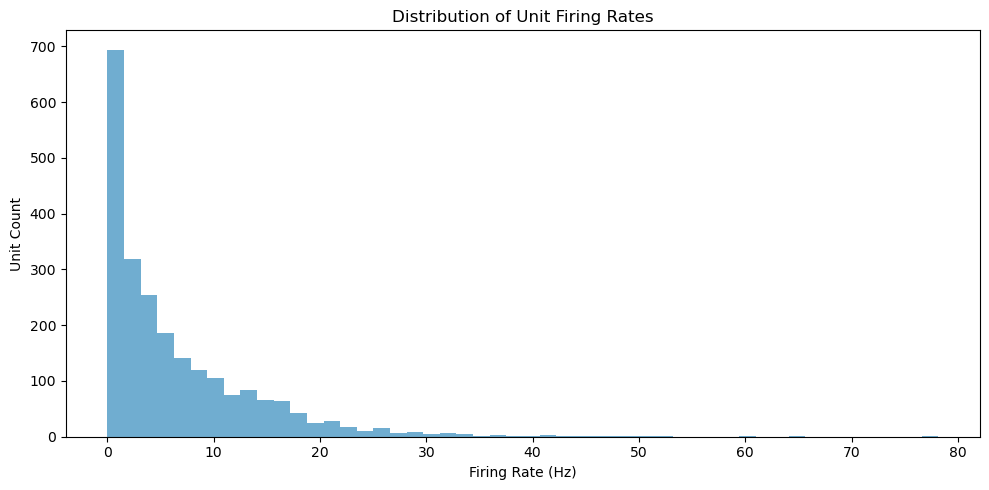

In [6]:
# Load units data efficiently without full DataFrame conversion for exploration
unit_qualities = nwb.units['quality'][:]
total_units = len(unit_qualities)

# Count units by quality
unique_qualities, counts = np.unique(unit_qualities, return_counts=True)
qc_summary = dict(zip(unique_qualities, counts))

print(f"Total spike-sorted units: {total_units}")
print("\nUnit quality distribution:")
for quality, count in qc_summary.items():
    print(f"  {quality}: {count}")

# Get firing rates for visualization
units_df = nwb.units.to_dataframe()
firing_rates = units_df['firing_rate'].dropna()

plt.figure(figsize=(10, 5))
plt.hist(firing_rates, bins=50, color="#348ABD", alpha=0.7)
plt.xlabel('Firing Rate (Hz)')
plt.ylabel('Unit Count')
plt.title('Distribution of Unit Firing Rates')
plt.tight_layout()
plt.show()

## Accessing Spike Times

The correct way to access spike times is via `nwb.units.spike_times_index[i]` for the i-th unit.

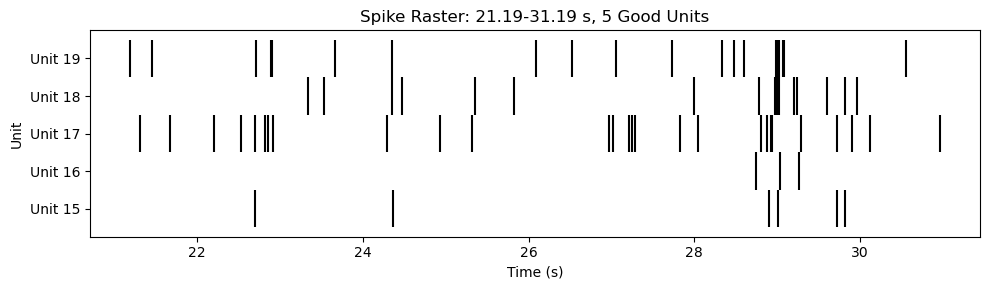

In [7]:
# Find units with good quality for demonstration
good_unit_indices = [i for i, quality in enumerate(unit_qualities) if quality == 'good']

# Get spike times for first 5 good units
sample_unit_indices = good_unit_indices[:5]
spike_trains = [nwb.units.spike_times_index[i] for i in sample_unit_indices]

# Find the earliest spike to center our visualization window
all_spikes = np.concatenate([st for st in spike_trains if len(st) > 0])
if len(all_spikes) > 0:
    t_start = all_spikes.min()
    t_stop = t_start + 10  # Show 10 second window
    
    # Extract spikes in the time window for each unit
    plot_spikes = [st[(st >= t_start) & (st < t_stop)] for st in spike_trains]
    
    plt.figure(figsize=(10, 3))
    for i, st in enumerate(plot_spikes):
        plt.vlines(st, i + 0.5, i + 1.5, color='k')
    
    unit_ids = nwb.units.id[:]
    plt.yticks(np.arange(1, 6), [f"Unit {unit_ids[idx]}" for idx in sample_unit_indices])
    plt.xlabel('Time (s)')
    plt.ylabel('Unit')
    plt.title(f'Spike Raster: {t_start:.2f}-{t_stop:.2f} s, 5 Good Units')
    plt.tight_layout()
    plt.show()
else:
    print("No spikes found in selected units")

## Stimulus Structure and Timing

This dataset contains multiple types of visual stimuli organized as detailed interval tables.

RepeatFFF presentations: 43200 trials

Stimulus properties (first 5 trials):
    contrast  orientation spatial_frequency            size units
id                                                               
0        1.0          0.0        [0.0, 0.0]  [250.0, 250.0]   deg
1        1.0          0.0        [0.0, 0.0]  [250.0, 250.0]   deg
2        1.0          0.0        [0.0, 0.0]  [250.0, 250.0]   deg
3        1.0          0.0        [0.0, 0.0]  [250.0, 250.0]   deg
4        1.0          0.0        [0.0, 0.0]  [250.0, 250.0]   deg


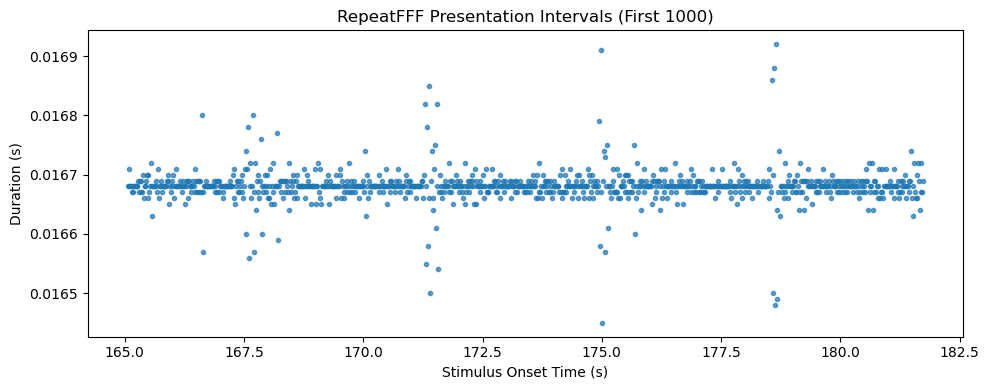

In [8]:
# Explore the RepeatFFF stimulus intervals
repeatfff_df = nwb.intervals['RepeatFFF_presentations'].to_dataframe()

print(f"RepeatFFF presentations: {len(repeatfff_df)} trials")
print("\nStimulus properties (first 5 trials):")
properties = ['contrast', 'orientation', 'spatial_frequency', 'size', 'units']
print(repeatfff_df[properties].head())

# Visualize stimulus timing for first 1000 presentations
onsets = repeatfff_df['start_time'].values[:1000]
durations = (repeatfff_df['stop_time'] - repeatfff_df['start_time']).values[:1000]

plt.figure(figsize=(10, 4))
plt.plot(onsets, durations, '.', alpha=0.7)
plt.xlabel('Stimulus Onset Time (s)')
plt.ylabel('Duration (s)')
plt.title('RepeatFFF Presentation Intervals (First 1000)')
plt.tight_layout()
plt.show()

## Behavioral Data

The dataset includes behavioral tracking data for running and eye movements.

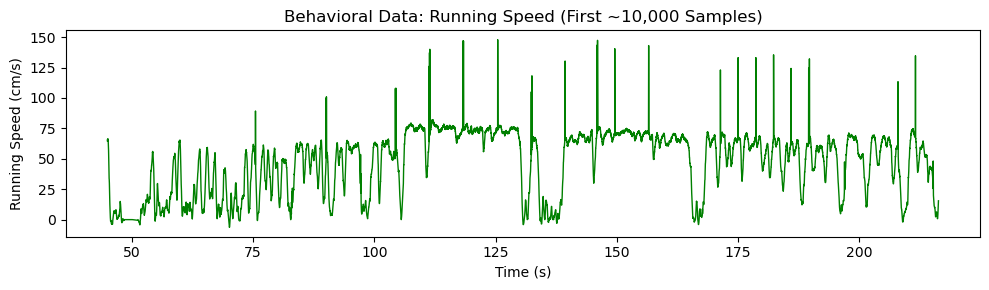

In [9]:
# Access running speed data
running_speed_ts = nwb.processing['running'].data_interfaces['running_speed']
running_speed = running_speed_ts.data[:10000]  # First 10,000 samples for demo
running_time = running_speed_ts.timestamps[:10000]

plt.figure(figsize=(10, 3))
plt.plot(running_time, running_speed, color='green', lw=1)
plt.xlabel('Time (s)')
plt.ylabel('Running Speed (cm/s)')
plt.title('Behavioral Data: Running Speed (First ~10,000 Samples)')
plt.tight_layout()
plt.show()

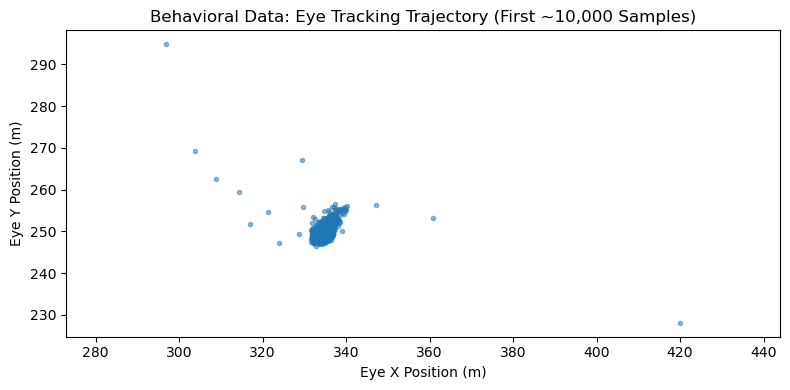

In [10]:
# Access eye tracking data
eye_tracking = nwb.acquisition['EyeTracking'].eye_tracking
eyedata = eye_tracking.data[:10000]  # (N, 2) array with [x, y] positions

plt.figure(figsize=(8, 4))
plt.plot(eyedata[:, 0], eyedata[:, 1], '.', alpha=0.5)
plt.xlabel('Eye X Position (m)')
plt.ylabel('Eye Y Position (m)')
plt.title('Behavioral Data: Eye Tracking Trajectory (First ~10,000 Samples)')
plt.axis('equal')
plt.tight_layout()
plt.show()

## Optogenetic Stimulation Data

In [11]:
# Access optogenetic stimulation intervals
opto_df = nwb.processing['optotagging'].data_interfaces['optogenetic_stimulation'].to_dataframe()

print("Optogenetic stimulation summary:")
print(f"Total stimulation epochs: {len(opto_df)}")
print("\nFirst 5 stimulation intervals:")
print(opto_df[['start_time', 'stop_time', 'level', 'stimulus_name']].head())

Optogenetic stimulation summary:
Total stimulation epochs: 450

First 5 stimulation intervals:
    start_time   stop_time  level      stimulus_name
id                                                  
0   7270.95571  7271.95571   1.94   5 hz pulse train
1   7273.09679  7274.09679   1.94      raised_cosine
2   7275.06681  7276.06681   2.05      raised_cosine
3   7276.87680  7277.87680   1.94   5 hz pulse train
4   7278.99756  7279.99756   2.05  40 hz pulse train


## Finding Stimulus-Responsive Units

Rather than plotting arbitrary units, it's better to identify units that respond to specific stimuli.

Most responsive unit: index 549
Spikes in ±50ms window across 100 trials: 1079


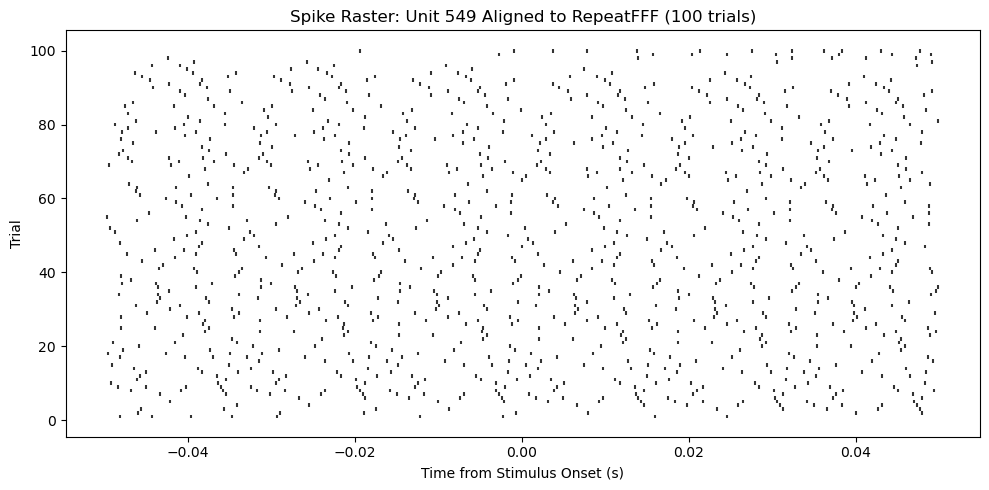

In [12]:
# Function to efficiently search for responsive units
def count_aligned_spikes(spike_times, onsets, window):
    """Count spikes aligned to stimulus onsets within a time window."""
    return sum(np.sum((spike_times >= onset + window[0]) & (spike_times < onset + window[1])) 
               for onset in onsets)

# Get RepeatFFF onsets for analysis
onsets = repeatfff_df['start_time'].values[:100]  # Use first 100 trials for efficiency
window = [-0.05, 0.05]  # 50 ms pre/post stimulus

# Screen units for stimulus responsiveness
spike_counts = []
for i in range(len(nwb.units.id)):
    spike_times = nwb.units.spike_times_index[i]
    count = count_aligned_spikes(spike_times, onsets, window)
    spike_counts.append(count)

# Find most responsive unit
best_unit_idx = int(np.argmax(spike_counts))
print(f"Most responsive unit: index {best_unit_idx}")
print(f"Spikes in ±50ms window across 100 trials: {spike_counts[best_unit_idx]}")

# Generate raster for most responsive unit if it has sufficient activity
if spike_counts[best_unit_idx] > 10:  # Only plot if unit shows reasonable activity
    spike_times = nwb.units.spike_times_index[best_unit_idx]
    rasters = []
    for onset in onsets:
        aligned_spikes = spike_times[(spike_times >= onset + window[0]) & 
                                   (spike_times < onset + window[1])] - onset
        rasters.append(aligned_spikes)
    
    plt.figure(figsize=(10, 5))
    for i, spikes in enumerate(rasters):
        plt.vlines(spikes, i+0.5, i+1.5, color='k', alpha=0.8)
    plt.xlabel('Time from Stimulus Onset (s)')
    plt.ylabel('Trial')
    plt.title(f'Spike Raster: Unit {best_unit_idx} Aligned to RepeatFFF (100 trials)')
    plt.tight_layout()
    plt.show()
else:
    print("No units with sufficient stimulus-aligned activity found in this sample.")

## Summary

This notebook demonstrated how to:

- Access and explore the structure of Dandiset 000563
- Load NWB session files efficiently via remote streaming
- Navigate spike-sorted units and behavioral data
- Understand stimulus presentation timing and parameters
- Find stimulus-responsive units for targeted analysis
- Access optogenetic stimulation data

The dataset is well-suited for investigating temporal precision in visual responses, "barcode" patterns in neural activity, and multi-modal analyses incorporating behavior and optogenetics.

**Key considerations for analysis:**
- Use `nwb.units.spike_times_index[i]` for efficient spike time access
- LFP data is in separate probe files with timestamps in milliseconds
- Screen for responsive units before detailed analyses
- Leverage rich stimulus and behavioral metadata for condition-specific studies